## Решение задачи 1 booster-tinkoff

2017, Александр Дьяконов

https://alexanderdyakonov.wordpress.com/

In [16]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np


# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Droid Sans',
        'weight': 'normal'}
rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


In [18]:
train = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';', decimal=',')
test = pd.read_csv('credit_test.csv', encoding='cp1251', sep=';', decimal=',')

test['open_account_flg'] = 0.5
data = pd.concat([train, test])

data.drop('client_id', 1, inplace=True)
print (data.shape)
data[:5]

(262686, 14)


,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0.0
1,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0.0
2,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0.0
3,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0.0
4,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0.0


## обрабатываем регионы

In [ ]:
# обработка поля регион
def cleanregion(x):
    x = x.replace('74', 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ')
    x = x.replace('98', 'САНКТ-ПЕТЕРБУРГ')
    x = x.replace('МОСКВА Г', 'МОСКВА')
    x = x.replace('МОСКВОСКАЯ', 'МОСКОВСКАЯ')
    x = x.replace('МЫТИЩИНСКИЙ', 'МОСКОВСКАЯ')
    x = x.replace('СЕВ.', 'СЕВЕРНАЯ')
    
    words = ['ОКРУГ', 'Г ' , ' ', 'Р-Н', '-', 'Г.', '.', '(', ')', '/', '\\', 'АВТОНОМНАЯ', 'ОБЛАСТЬ', 'АОБЛ', 'ОБЛ', 'РЕСПУБЛИКА', 'РЕСП', '', 'АВТОНОМНЫЙ',
             'КРАЙ', 'ЧУВАШИЯ', 'АЛАНИЯ', 'ЮГРА', 'АО', 'АO', 'ЯКУТИЯ']
    for w in words:
        x = x.replace(w, '')
        
    x = x.replace('ИЙ', 'АЯ')
    x = x.replace('ГОРЬКОВСКАЯ', 'НИЖЕГОРОДСКАЯ')
    x = x.replace('ГУСЬХРУСТАЛЬНЫЙ', 'ВЛАДИМИРСКАЯ')
    x = x.replace('ДАЛЬНАЯВОСТОК', 'ХАБАРОВСКАЯ')
    x = x.replace('ОДИНЦОВОМОСКОВСКАЯ', 'МОСКВА')
    x = x.replace('ОРЁЛ', 'ОРЛОВСКАЯ')
    x = x.replace('ПРИВОЛЖСКАЯФЕДЕРАЛЬНЫЙ', 'НИЖЕГОРОДСКАЯ')
    x = x.replace('РОССИЯ', 'МОСКВА')
    x = x.replace('ЭВЕНКАЯСКАЯ', 'КРАСНОЯРСКАЯ')
    x = x.replace('КАМЧАТС??АЯ', 'КАМЧАТСКАЯ')
    x = x.replace('МОСКОВСКАЯП', 'МОСКОВСКАЯ')
    x = x.replace('ЧЕЛЯБИНСК', 'ЧЕЛЯБИНСКАЯ')
    x = x.replace('ЧЕЛЯБИНСКАЯАЯ', 'ЧЕЛЯБИНСКАЯ')

    return (x)

# кодирование по мощности + шум
def volumecode(data, name):
    tmp = data.groupby(name)[name].count()
    tmp += 0.001 * np.random.rand(tmp.shape[0])
    return(data[name].map(tmp))

# удаление мелких категорий
def delsmallcats(data, name, th_small=100):
    tmp = data[name].value_counts()
    big_cats = tmp[tmp > th_small].index.tolist() # больше категории
    data.loc[~data[name].isin(big_cats), name] = data[name].min() - 1 # заменить мелкие одной
    return (data[name])

### готовим признаки

In [4]:
# data['nan_count'] = data.isnull().sum(1) # число неизвестных значений
data.gender = data.gender.map({'M': 1.0, 'F': 0.0}) # пол

data['monthly_income_round'] = 0 + (np.round(data.monthly_income.values, -1) == data.monthly_income.values)
data['monthly_income_round'] += (np.round(data.monthly_income.values, -2) == data.monthly_income.values)
data['monthly_income_round'] += (np.round(data.monthly_income.values, -3) == data.monthly_income.values)
data['monthly_income_round'] += (np.round(data.monthly_income.values, -4) == data.monthly_income.values)
data['monthly_income_round'] += (np.round(data.monthly_income.values, -5) == data.monthly_income.values)

data['credit_sum_round'] = 0 + (np.round(data.credit_sum.values, -1) == data.credit_sum.values)
data['credit_sum_round'] += (np.round(data.credit_sum.values, -2) == data.credit_sum.values)
data['credit_sum_round'] += (np.round(data.credit_sum.values, -3) == data.credit_sum.values)
data['credit_sum_round'] += (np.round(data.credit_sum.values, -4) == data.credit_sum.values)

data.credit_sum = np.log(data.credit_sum + 1.0) # приводим к колокольчику
mean_credit_sum = data.credit_sum.mean()
data.credit_sum.fillna(mean_credit_sum, inplace=True)

data.monthly_income = np.log(data.monthly_income + 1.0) # приводим к колокольчику
mean_monthly_income = data.monthly_income.mean()
data.monthly_income.fillna(mean_monthly_income, inplace=True)

data['delta_sums'] = data.credit_sum - data.monthly_income # разница кредита и дохода

data.tariff_id = data.tariff_id.map(lambda x: float(x)).astype(float) # там почему-то строки

data['tariff_id_factor'] = data.tariff_id
data['credit_month_factor'] = data.credit_month
data['living_region'].fillna('OTHER', inplace=True)
data['old_region'] = data['living_region'] # volumecode(data, 'living_region')
data['living_region'] = data['living_region'].astype(str).map(cleanregion)

data['overdue_credit_count'].fillna(data['overdue_credit_count'].max() + 1, inplace=True)
data['credit_count'].fillna(data['credit_count'].max() + 1, inplace=True)

In [5]:
data[:5]

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,monthly_income_round,credit_sum_round,delta_sums,tariff_id_factor,credit_month_factor,old_region
0,1.0,48,MAR,UMN,11.002083,10,1.6,0.770249,GRD,КРАСНОДАРСКАЯ,10.308986,1.0,1.0,0.0,4,0,0.693097,1.6,10,КРАСНОДАРСКИЙ КРАЙ
1,0.0,28,MAR,UMN,9.295600,6,1.1,0.248514,GRD,МОСКВА,10.668979,2.0,0.0,0.0,3,0,-1.373378,1.1,6,МОСКВА
2,1.0,32,MAR,SPC,9.280706,12,1.1,0.459589,SCH,САРАТОВСКАЯ,10.043293,5.0,0.0,0.0,3,0,-0.762587,1.1,12,ОБЛ САРАТОВСКАЯ
3,0.0,27,DIV,SPC,9.393502,12,1.1,0.362536,GRD,ВОЛГОГРАДСКАЯ,9.741027,2.0,0.0,0.0,3,0,-0.347525,1.1,12,ОБЛ ВОЛГОГРАДСКАЯ
4,1.0,45,MAR,SPC,9.735654,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,10.126671,1.0,0.0,0.0,3,0,-0.391017,1.1,10,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ


In [6]:
catfeatures = ['marital_status', 'job_position',
               'credit_month_factor', 'tariff_id_factor',
               'education', 'living_region',
               'old_region']

for name in catfeatures:
    data[name] = volumecode(data, name)
    a = data[name].nunique()
    # data[name] = delsmallcats(data, name)
    print (name, a, data[name].nunique())

marital_status 5 5
job_position 18 18
credit_month_factor 31 31
tariff_id_factor 32 32
education 5 5
living_region 86 86
old_region 318 318


In [7]:
from itertools import combinations

newcats = []

for i, j in combinations(catfeatures + ['gender'], 2):
    name = str(i) + ' + ' + str(j)
    data[name] = data[i].astype(str) + '+' + data[j].astype(str)
    data[name] = volumecode(data, name)
    newcats.append(name)
    print (i, j, data[name].nunique())

marital_status job_position 81
marital_status credit_month_factor 132
marital_status tariff_id_factor 137
marital_status education 25
marital_status living_region 425
marital_status old_region 1168
marital_status gender 10
job_position credit_month_factor 272
job_position tariff_id_factor 272
job_position education 74
job_position living_region 1018
job_position old_region 2061
job_position gender 35
credit_month_factor tariff_id_factor 252
credit_month_factor education 118
credit_month_factor living_region 1499
credit_month_factor old_region 2897
credit_month_factor gender 59
tariff_id_factor education 122
tariff_id_factor living_region 1368
tariff_id_factor old_region 2698
tariff_id_factor gender 63
education living_region 373
education old_region 975
education gender 10
living_region old_region 318
living_region gender 172
old_region gender 566


## данные для тестов

In [9]:
X = data[data.open_account_flg!=0.5]
X2 = data[data.open_account_flg==0.5]
y = X['open_account_flg']
y2 = X2['open_account_flg']
X.drop('open_account_flg', inplace=True, axis=1)
X2.drop('open_account_flg', inplace=True, axis=1)
print (X.shape, y.shape, X2.shape, y2.shape)
# (170746, 46) (170746,) (91940, 46) (91940,)

(170746, 47) (170746,) (91940, 47) (91940,)


In [10]:
from  sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from time import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print (train.shape, test.shape, y_train.shape, y_test.shape)

(136596, 47) (34150, 47) (136596,) (34150,)


In [69]:
gbm = lgb.LGBMClassifier(objective='binary', colsample_bytree=0.5,
                         learning_rate=0.06, max_bin=452,
                         max_depth=5, min_child_samples=2,
                         min_child_weight=25, min_split_gain=0.00,
                         num_leaves=324, reg_alpha=0.01, reg_lambda=0.00,
                         subsample=0.9, subsample_for_bin=15069, subsample_freq=0,
                         n_estimators=200)

gbm.fit(train, y_train, categorical_feature=catfeatures) # , eval_set=[(test, y_test)], eval_metric='auc', early_stopping_rounds=5)
a_gbm = gbm.predict_proba(test)[:, 1]
print (roc_auc_score(y_test, a_gbm))
# всё - ohe - 0.774861037007
# 0.777343251116
# 0.7741 0.7768


#0.772458858042

0.77516317769


0.776537235013


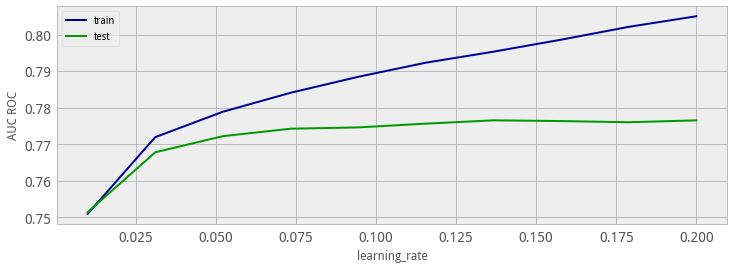

In [14]:
import lightgbm as lgb

name = 'learning_rate'
lspace = np.linspace(0.01, 0.2, 10) # np.round(np.linspace(1, 100, 20)).astype(int) #  # np.round(np.linspace(10, 100000, 20)).astype(int) # np.linspace(0.1, 1.0, 20) #np.linspace(0.0, 10.0, 20) #np.round(np.linspace(2, 500, 20)).astype(int) # np.linspace(0.0, 0.1, 20) #np.round(np.arange(10) + 1).astype(int) # np.linspace(1, 500, 20)

params = {'learning_rate': 0.15,
          'max_depth': 5,
          'n_estimators': 200
         }



e_train = []
e_test = []

for x in lspace:
    params[name] = x
    gbm = lgb.LGBMClassifier(objective='binary',
                             learning_rate=params['learning_rate'],
                             max_depth=params['max_depth'],
                             n_estimators=params['n_estimators'])
    gbm.fit(train, y_train, categorical_feature=catfeatures)
    a1_gbm = gbm.predict_proba(train)[:, 1]
    a2_gbm = gbm.predict_proba(test)[:, 1]
    e_train.append(roc_auc_score(y_train, a1_gbm))
    e_test.append(roc_auc_score(y_test, a2_gbm))
    
figsize(12, 4)
plt.plot(lspace, e_train, c='#000099', label='train', lw=2)
plt.plot(lspace, e_test, c='#009900', label='test', lw=2)
plt.xlabel(name)
plt.ylabel('AUC ROC')
plt.legend(loc='best')
#plt.xlim([-1, 10])
#plt.ylim([0.75, 0.85])
print(max(e_test))    

depth=3, auc=0.773, time=  8.9
depth=5, auc=0.776, time=   11
depth=7, auc=0.776, time=   12


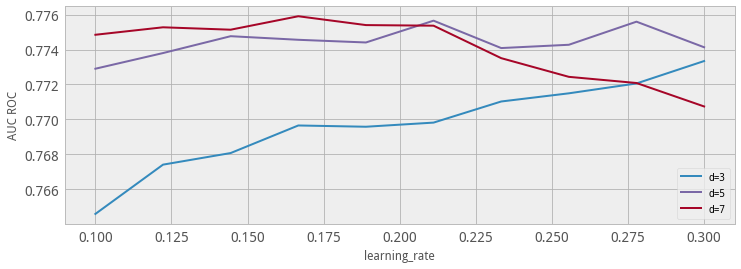

In [11]:
import lightgbm as lgb

figsize(12, 4)

name = 'learning_rate'
lspace = np.linspace(0.1, 0.3, 10) # np.round(np.linspace(1, 100, 20)).astype(int) #  # np.round(np.linspace(10, 100000, 20)).astype(int) # np.linspace(0.1, 1.0, 20) #np.linspace(0.0, 10.0, 20) #np.round(np.linspace(2, 500, 20)).astype(int) # np.linspace(0.0, 0.1, 20) #np.round(np.arange(10) + 1).astype(int) # np.linspace(1, 500, 20)

for d in [3, 5, 7]:
    e_test = []
    tm = time()
    for lr in lspace:
        gbm = lgb.LGBMClassifier(objective='binary',
                                 learning_rate=lr,
                                 max_depth=d,
                                 n_estimators=100)
        
        gbm.fit(train, y_train, categorical_feature=['living_region']) # , categorical_feature=catfeatures newcats catfeatures
        
        a2_gbm = gbm.predict_proba(test)[:, 1]
        
        e = roc_auc_score(y_test, a2_gbm)
        e_test.append(e)
    
    print ('depth=%g, auc=%2.3g, time=%5.2g' % (d, max(e_test), time()-tm) )
    
    plt.plot(lspace, e_test, label='d='+str(d), lw=2) #c='#009900', 

plt.xlabel(name)
plt.ylabel('AUC ROC')
plt.legend(loc='best')

In [ ]:

depth=3, auc=0.771, time=    5
depth=5, auc=0.776, time=    6
depth=7, auc=0.776, time=    7

# depth=3, auc=0.773, time=  4.8
# depth=5, auc=0.775, time=  5.7
# depth=7, auc=0.776, time=  6.5

depth=3, auc=0.774, time=  8.9
depth=5, auc=0.777, time=   10
depth=7, auc=0.778, time=   12

depth=3, auc=0.774, time=    9
depth=5, auc=0.776, time=  9.9
depth=7, auc=0.777, time=   15


In [12]:
cat_tmp = catfeatures + newcats

depth=2, auc=0.771, time=  7.8
depth=3, auc=0.774, time=  8.2


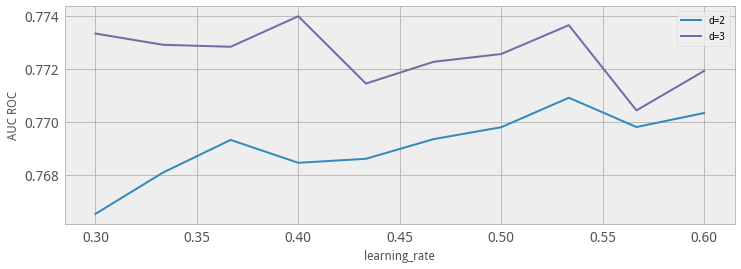

In [15]:
import lightgbm as lgb

figsize(12, 4)

name = 'learning_rate'
lspace = np.linspace(0.3, 0.6, 10) # np.round(np.linspace(1, 100, 20)).astype(int) #  # np.round(np.linspace(10, 100000, 20)).astype(int) # np.linspace(0.1, 1.0, 20) #np.linspace(0.0, 10.0, 20) #np.round(np.linspace(2, 500, 20)).astype(int) # np.linspace(0.0, 0.1, 20) #np.round(np.arange(10) + 1).astype(int) # np.linspace(1, 500, 20)

for d in [2, 3]:
    e_test = []
    tm = time()
    for lr in lspace:
        gbm = lgb.LGBMClassifier(objective='binary',
                                 learning_rate=lr,
                                 max_depth=d,
                                 n_estimators=100)
        
        gbm.fit(train, y_train, categorical_feature=['living_region']) # , categorical_feature=catfeatures newcats catfeatures
        
        a2_gbm = gbm.predict_proba(test)[:, 1]
        
        e = roc_auc_score(y_test, a2_gbm)
        e_test.append(e)
    
    print ('depth=%g, auc=%2.3g, time=%5.2g' % (d, max(e_test), time()-tm) )
    
    plt.plot(lspace, e_test, label='d='+str(d), lw=2) #c='#009900', 

plt.xlabel(name)
plt.ylabel('AUC ROC')
plt.legend(loc='best')

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(gbm, X, y, cv=3, n_jobs=-1)

array([ 0.8305046 ,  0.82741233,  0.82904031])